<a href="https://colab.research.google.com/github/Danata117/ML/blob/main/ML_Praktika5_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 5.2

По итоговому датасету:

1. Преобразовать текстовые данные (очистка + токенизация + нормализация).
2. Обучить модель **Word2Vec** на текстах.
3. Заполнить пропуски в числовых признаках через **SimpleImputer**.
4. Выбрать алгоритм **кластеризации** и построить кластеры.
5. Построить модель для **предсказания кластера** (supervised) с подбором гиперпараметров через **GridSearchCV**.


In [3]:
!pip install pymorphy3 gensim scikit-learn nltk # бибилотеки с которыми будем работать

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 99.9 MB/s eta 0:00:00


In [4]:
# Базовые импорты
import pandas as pd
import numpy as np


In [5]:

import sqlite3
conn = sqlite3.connect("vladivostok_news.db")
df = pd.read_sql_query("SELECT * FROM articles;", conn)
conn.close()

In [6]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

from pymorphy3 import MorphAnalyzer

import re
import nltk
from nltk.corpus import stopwords

Пояснения к датасету:

Данная база данных содержит информацио о статьях и сами статьи с сайта newsvl.ru.

guid - уникальный идентификатор записи, тип UUID v4

title - текстовый заголовок

description	- текст статьи

url - ссылка на статью

published_at - Дата публикации (без времени)

comments_count - количество комментариев (на сайте newsvl.ru нет комментариев, поэтому кол-во равно нулю по умолчанию)

created_at_utc - время сохранения в базу данных

rating - рейтинг (его нет на сайте, None по умолчанию)

word_count - кол-во слов в статье

In [7]:
df.head()

,guid,title,description,url,published_at,comments_count,created_at_utc,rating,word_count
0,b78c12f4-2675-4bce-9ec2-d9f6a645734e,«Стоимость проезда должна равняться литру топл...,Под конец года перевозчики подали обращение в ...,https://www.newsvl.ru/vlad/2025/12/18/235760/,2025-12-18 00:00:00,0,2025-12-19 01:57:54,None,404
1,665826ae-66ba-44aa-a98c-2d16e77aecf7,«Киллер белорусского плавания»: пловец с наруш...,Четыре заплыва и четыре золотые медали – 17-ле...,https://www.newsvl.ru/sport/2025/12/18/235759/,2025-12-18 00:00:00,0,2025-12-19 01:57:55,None,863
2,2527cd1b-0401-42d4-ac18-3c2e7fac567b,Сегодня во Владивостоке до +3 °С,"Во Владивостоке в пятницу, 19 декабря, утром н...",https://www.newsvl.ru/vlad/2025/12/19/235761/,2025-12-19 00:00:00,0,2025-12-19 01:57:55,None,50
3,87b78abb-95cb-4f51-93ce-85521ba026d6,Во Владивостоке подключили камеры для штрафов ...,Во Владивостоке установили и подключили компле...,https://www.newsvl.ru/vlad/2025/12/18/235758/,2025-12-18 00:00:00,0,2025-12-19 01:57:55,None,441
4,ada7970c-53ad-4d47-ac25-1b6e94d39341,"На Шилкинской, возможно, закроют ещё одну авто...","Участок на Шилкинской, 21 во Владивостоке, где...",https://www.newsvl.ru/vlad/2025/12/18/235756/,2025-12-18 00:00:00,0,2025-12-19 01:57:55,None,485


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   guid            5000 non-null   object
 1   title           5000 non-null   object
 2   description     5000 non-null   object
 3   url             5000 non-null   object
 4   published_at    5000 non-null   object
 5   comments_count  5000 non-null   int64 
 6   created_at_utc  5000 non-null   object
 7   rating          0 non-null      object
 8   word_count      5000 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 351.7+ KB


Приведём строковые даты к datetime, чтобы с ними можно было работать как с временными признаками.

In [9]:
df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")
df["created_at_utc"] = pd.to_datetime(df["created_at_utc"], errors="coerce")

df[["published_at", "created_at_utc"]].head()

,published_at,created_at_utc
0,2025-12-18,2025-12-19 01:57:54
1,2025-12-18,2025-12-19 01:57:55
2,2025-12-19,2025-12-19 01:57:55
3,2025-12-18,2025-12-19 01:57:55
4,2025-12-18,2025-12-19 01:57:55


## Предобработка

In [10]:
import re
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
import nltk

nltk.download("stopwords")

morph = MorphAnalyzer()

STOP_RU = set(stopwords.words("russian"))
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)

def preprocess_text(text: str):
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.lower()
    tokens = TOKEN_RE.findall(text)

    lemmas = []
    for token in tokens:
        # Отсекаем короткий мусор
        if len(token) <= 2:
            continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-я]", token):
            # Русское слово: нормальная форма через pymorphy3
            if token in STOP_RU:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in STOP_RU:
                continue
        else:
            # Латинское/английское слово — оставляем как есть
            lemma = token

        lemmas.append(lemma)

    return lemmas


tokenized_texts = df["description"].astype(str).apply(preprocess_text).tolist()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
sample_text = df["description"].iloc[0]
print(sample_text[:100], "...")

preprocess_text(sample_text)[:100]

Под конец года перевозчики подали обращение в администрацию Владивостока с просьбой установить эконо ...


['конец',
 'год',
 'перевозчик',
 'подать',
 'обращение',
 'администрация',
 'владивосток',
 'просьба',
 'установить',
 'экономически',
 'обоснованный',
 'тариф',
 'проезд',
 'подписаться',
 'обращение',
 'объяснять',
 'топливо',
 'запчасть',
 'аренда',
 'подорожать',
 'автобус',
 'работать',
 'минус',
 'расча',
 'тный',
 'тариф',
 'учитывать',
 'затрата',
 'составить',
 'менее',
 'рубль',
 'компания',
 'понимать',
 'столько',
 'проезд',
 'стоить',
 'мэрия',
 'искать',
 'компромисс',
 'предприниматель',
 'пассажир',
 'январь',
 'владивосток',
 'повысить',
 'стоимость',
 'проезд',
 'автобус',
 'рубль',
 'зависимость',
 'способ',
 'оплата',
 'администрация',
 'объяснить',
 'решение',
 'принять',
 'рассмотрение',
 'экономический',
 'расча',
 'тов',
 'компания',
 'перевозчик',
 'лето',
 'автобусник',
 'вновь',
 'попросить',
 'поднять',
 'тариф',
 'рубль',
 'обращение',
 'подписаться',
 'компания',
 'например',
 'самокат',
 'считать',
 'перекладывать',
 'пассажир',
 'нужный',
 'брутто',
 'к

In [12]:
N_DOCS = 5000  # для демонстрации; нужно увеличить до len(df)

texts = df["description"].iloc[:N_DOCS].tolist()

tokenized_texts = [preprocess_text(t) for t in texts]

# Смотрим пример
tokenized_texts[0][:40]

['конец',
 'год',
 'перевозчик',
 'подать',
 'обращение',
 'администрация',
 'владивосток',
 'просьба',
 'установить',
 'экономически',
 'обоснованный',
 'тариф',
 'проезд',
 'подписаться',
 'обращение',
 'объяснять',
 'топливо',
 'запчасть',
 'аренда',
 'подорожать',
 'автобус',
 'работать',
 'минус',
 'расча',
 'тный',
 'тариф',
 'учитывать',
 'затрата',
 'составить',
 'менее',
 'рубль',
 'компания',
 'понимать',
 'столько',
 'проезд',
 'стоить',
 'мэрия',
 'искать',
 'компромисс',
 'предприниматель']

## Обучение модели

In [13]:
from gensim.models import Word2Vec
import numpy as np

w2v = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,
    epochs=10,
)

def doc_vector(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

doc_vectors = np.vstack([doc_vector(t, w2v) for t in tokenized_texts])
doc_vectors.shape


(5000, 100)

In [14]:
w2v.wv.most_similar("пробка", topn=10)

[('затор', 0.841877281665802),
 ('сковать', 0.747738778591156),
 ('образовываться', 0.7094208002090454),
 ('выделенка', 0.7055920958518982),
 ('стояние', 0.7009547352790833),
 ('дальхимпром', 0.688481867313385),
 ('реверсивный', 0.6794708371162415),
 ('встречка', 0.6690983176231384),
 ('балльный', 0.6690576672554016),
 ('сткома', 0.6671156883239746)]

In [15]:
for test_word in ["пробка", "администрация", "автобус", "владивосток", "кожемяко"]:
    if test_word not in w2v.wv:
        continue

    print(f"\nПохожие слова для «{test_word}»:")
    for word, score in w2v.wv.most_similar(test_word, topn=5):
        print(f"  {word:15s} {score:.3f}")


Похожие слова для «пробка»:
  затор           0.842
  сковать         0.748
  образовываться  0.709
  выделенка       0.706
  стояние         0.701

Похожие слова для «администрация»:
  мэрия           0.775
  поручать        0.661
  мцу             0.644
  зеленвлад       0.642
  мку             0.639

Похожие слова для «автобус»:
  маршрутка       0.796
  маршрут         0.755
  электробус      0.741
  паз             0.734
  набиваться      0.713

Похожие слова для «владивосток»:
  город           0.675
  четверг         0.647
  вторник         0.604
  бракосочетание  0.597
  анонсироваться  0.597

Похожие слова для «кожемяко»:
  губернатор      0.835
  олег            0.757
  трутнеть        0.755
  полпред         0.699
  врио            0.697


In [16]:
def document_vector(tokens, model: Word2Vec):

    vectors = [model.wv[token] for token in tokens if token in model.wv]

    if not vectors:
        return np.zeros(model.vector_size, dtype="float32")

    return np.mean(vectors, axis=0)



doc_vectors = np.vstack([document_vector(tokens, w2v) for tokens in tokenized_texts])
doc_vectors.shape

(5000, 100)

In [17]:

doc_vectors[:3]

array([[-0.01012882,  0.29699746, -0.21039231, -0.01624682,  0.14229725,
        -0.1430903 , -0.05823899,  0.4487029 , -0.12826367, -0.21194677,
         0.10663595, -0.29123032, -0.22380447,  0.09951856, -0.04626418,
        -0.08817688, -0.01475203, -0.0902672 ,  0.05619364, -0.500631  ,
         0.14822534,  0.06605079,  0.04612615, -0.03744178,  0.15573032,
        -0.12035536, -0.16080539,  0.08617061, -0.26359043,  0.06043373,
         0.11175663, -0.20508774, -0.01046703, -0.25283825,  0.07663651,
         0.01101377,  0.02819824, -0.27257693, -0.02177966, -0.30262923,
        -0.00777423, -0.16761632, -0.1703258 ,  0.06125294,  0.14628364,
        -0.26444557, -0.22176212, -0.04695616,  0.03029347,  0.07960268,
         0.23988087, -0.23982951, -0.02003122,  0.12852389, -0.15355705,
        -0.1338915 ,  0.09838866, -0.08517677, -0.2896453 , -0.11524509,
         0.07502346,  0.09793293, -0.13490458,  0.03568285, -0.35330832,
         0.1906061 ,  0.05895291,  0.2716401 , -0.1

# KMeans с 4 кластерами

Кластеризация KMeans на 100-мерных векторах...

Создано кластеров: 4
Распределение по кластерам:
  Кластер 0: 2955 документов (59.1%)
  Кластер 1: 296 документов (5.9%)
  Кластер 2: 1534 документов (30.7%)
  Кластер 3: 215 документов (4.3%)


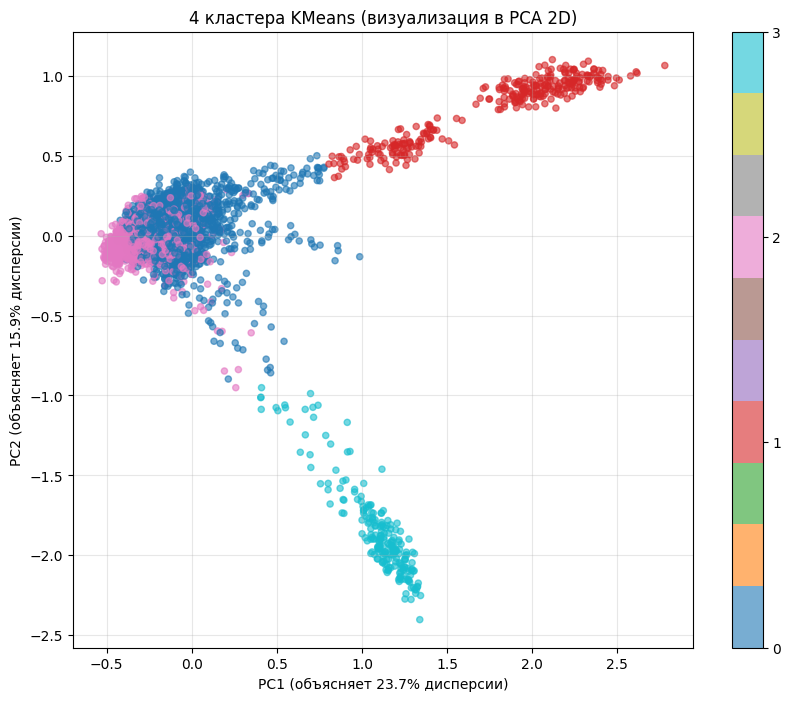


Разделение 100-мерных данных на train/test...
  X_train: (4000, 100) (100 признаков)
  X_test: (1000, 100) (100 признаков)
  y_train: (4000,)
  y_test: (1000,)

Обучение Decision Tree на 100-мерных данных...
Decision Tree accuracy: 0.925

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       591
           1       0.97      0.95      0.96        59
           2       0.92      0.85      0.88       307
           3       0.98      0.95      0.96        43

    accuracy                           0.93      1000
   macro avg       0.95      0.93      0.94      1000
weighted avg       0.93      0.93      0.92      1000



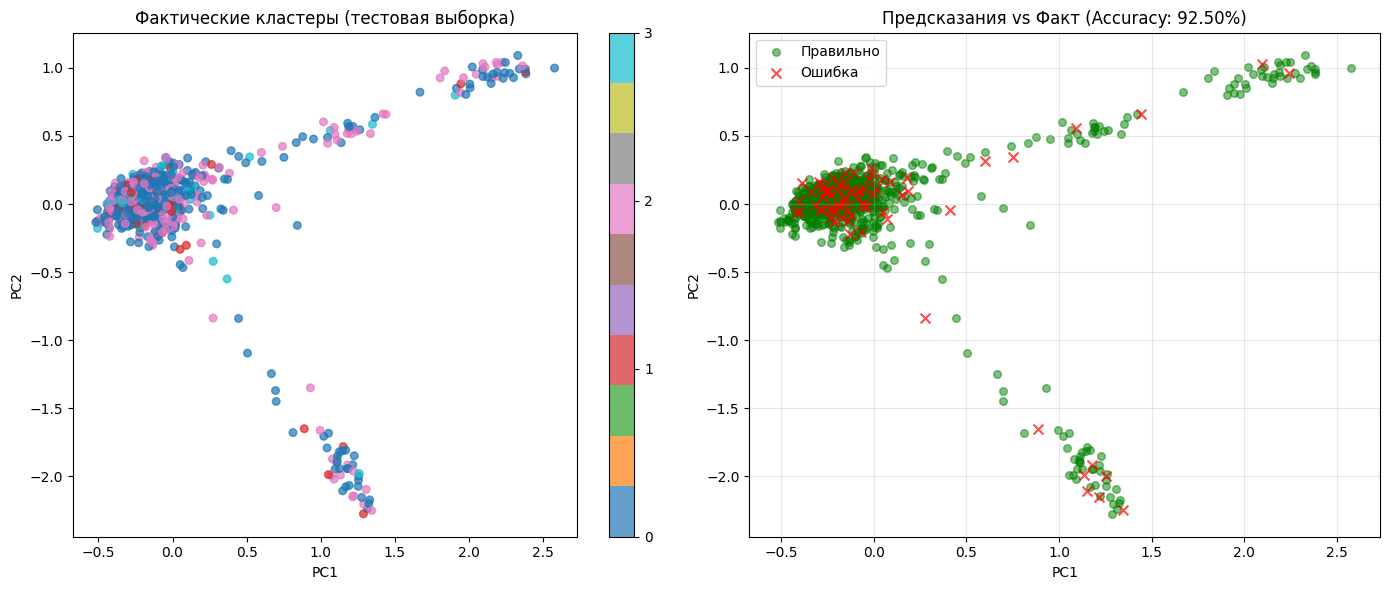

In [18]:
# ====== 1. СОХРАНЯЕМ PCA ДЛЯ ВИЗУАЛИЗАЦИИ ======
from sklearn.decomposition import PCA

# PCA для визуализации (2D)
pca = PCA(n_components=2, random_state=42)
doc_vectors_2d = pca.fit_transform(doc_vectors)  # doc_vectors_2d.shape = (5000, 2)

# ====== 2. КЛАСТЕРИЗАЦИЯ НА ПОЛНЫХ ДАННЫХ (100D) ======
from sklearn.cluster import KMeans

print("Кластеризация KMeans на 100-мерных векторах...")
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(doc_vectors)  # ← ВАЖНО: doc_vectors, а не doc_vectors_2d!

print(f"\nСоздано кластеров: {len(np.unique(labels))}")
print("Распределение по кластерам:")
unique, counts = np.unique(labels, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Кластер {cls}: {count} документов ({count/len(labels)*100:.1f}%)")

# ====== 3. ВИЗУАЛИЗАЦИЯ В 2D PCA ======
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(doc_vectors_2d[:, 0], doc_vectors_2d[:, 1],
                      c=labels, cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, ticks=range(4))
plt.title("4 кластера KMeans (визуализация в PCA 2D)")
plt.xlabel("PC1 (объясняет {:.1f}% дисперсии)".format(pca.explained_variance_ratio_[0]*100))
plt.ylabel("PC2 (объясняет {:.1f}% дисперсии)".format(pca.explained_variance_ratio_[1]*100))
plt.grid(True, alpha=0.3)
plt.show()

# ====== 4. РАЗДЕЛЕНИЕ ДАННЫХ (100D) ======
from sklearn.model_selection import train_test_split

print("\nРазделение 100-мерных данных на train/test...")
X_train, X_test, y_train, y_test = train_test_split(
    doc_vectors,  # ← 100-мерные вектора!
    labels,       # ← метки 0,1,2,3
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"  X_train: {X_train.shape} (100 признаков)")
print(f"  X_test: {X_test.shape} (100 признаков)")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")

# ====== 5. ОБУЧЕНИЕ МОДЕЛЕЙ НА 100D ДАННЫХ ======
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

print("\nОбучение Decision Tree на 100-мерных данных...")
dt_clf = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=10,
    random_state=42,
)

dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)

print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification report:")
print(classification_report(y_test, y_pred_dt))

# ====== 6. ДОПОЛНИТЕЛЬНО: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ В PCA ======
# Визуализируем правильные и неправильные предсказания в 2D
y_test_2d = y_test  # метки для тестовой выборки

# Находим индексы тестовых данных в оригинальном массиве
test_indices = np.random.choice(len(doc_vectors_2d), len(X_test), replace=False)
test_points_2d = doc_vectors_2d[test_indices]

# Разделяем на правильные и неправильные предсказания
correct = y_pred_dt == y_test
incorrect = ~correct

plt.figure(figsize=(14, 6))

# Левая картинка: фактические кластеры
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(test_points_2d[:, 0], test_points_2d[:, 1],
                      c=y_test, cmap='tab10', alpha=0.7, s=30)
plt.colorbar(scatter1, ticks=range(4))
plt.title("Фактические кластеры (тестовая выборка)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Правая картинка: предсказанные vs фактические
plt.subplot(1, 2, 2)
# Правильные предсказания
plt.scatter(test_points_2d[correct, 0], test_points_2d[correct, 1],
           c='green', alpha=0.5, s=30, label='Правильно')
# Неправильные предсказания
plt.scatter(test_points_2d[incorrect, 0], test_points_2d[incorrect, 1],
           c='red', alpha=0.7, s=50, marker='x', label='Ошибка')

plt.title(f"Предсказания vs Факт (Accuracy: {accuracy_score(y_test, y_pred_dt):.2%})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

МЕТОД K-NEAREST NEIGHBORS (KNN)

Базовый KNN (n_neighbors=5):
Accuracy: 0.9670

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       591
           1       0.98      1.00      0.99        59
           2       0.95      0.95      0.95       307
           3       0.96      1.00      0.98        43

    accuracy                           0.97      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.97      0.97      0.97      1000


ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ KNN (GridSearchCV)
Запуск GridSearchCV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
Лучшая точность на кросс-валидации: 0.9637

Лучший KNN на тестовой выборке:
Accuracy: 0.9690

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       591
           1       

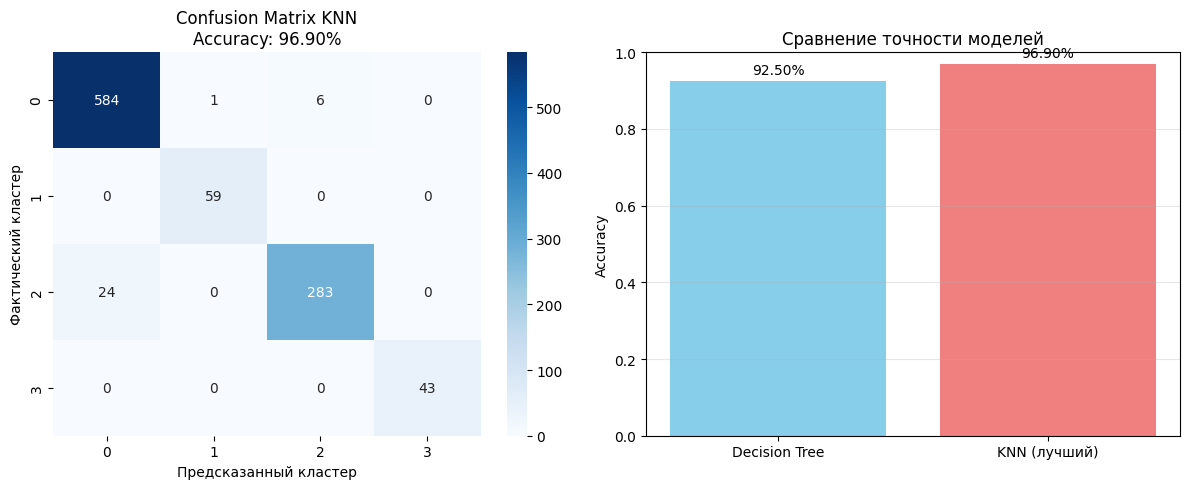


АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА СОСЕДЕЙ (k)


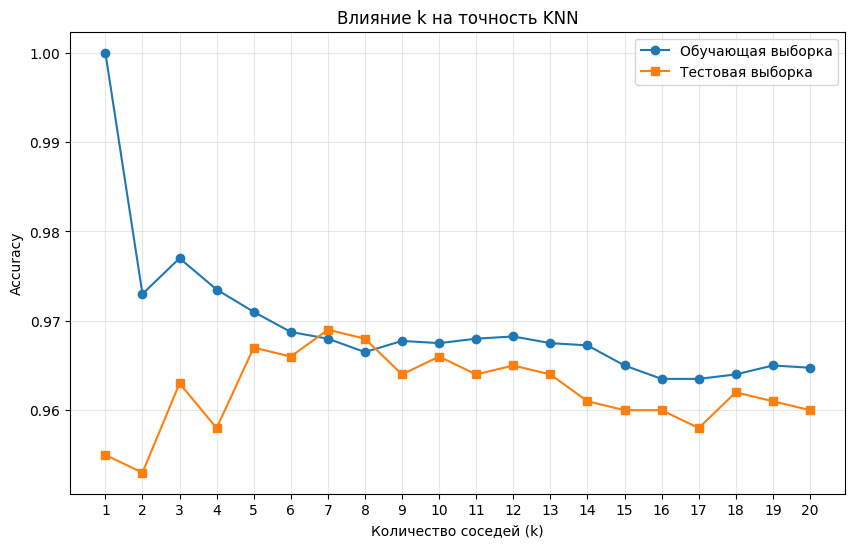

Лучшее k: 7 (accuracy: 0.9690)

ПРИМЕРЫ ПРЕДСКАЗАНИЙ KNN

Примеры предсказаний (первые 3 признака из 100):
Индекс   Предсказано  Факт     Правильно?   Расстояние до соседей
----------------------------------------------------------------------
521      0            0        ✓            [0 0 0]
737      0            0        ✓            [0 0 0]
740      0            0        ✓            [0 0 0]
660      0            0        ✓            [0 0 0]
411      0            0        ✓            [0 0 0]
678      2            2        ✓            [2 2 2]
626      0            0        ✓            [2 0 0]
513      0            0        ✓            [0 0 0]
859      0            0        ✓            [0 0 0]
136      1            1        ✓            [1 1 1]

ЧТО ОЗНАЧАЮТ КЛАСТЕРЫ? (по ближайшим соседям)

--- КЛАСТЕР 0 ---
Количество документов: 2364
Примеры заголовков:
  1. «Киллер белорусского плавания»: пловец с нарушением слуха из Владивостока собрал...
  2. На Шилкинской, возможно, зак

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ====== 1. БАЗОВЫЙ KNN ======
print("="*50)
print("МЕТОД K-NEAREST NEIGHBORS (KNN)")
print("="*50)

# Создаем KNN классификатор
knn = KNeighborsClassifier(
    n_neighbors=5,      # количество соседей
    weights='uniform',  # 'uniform' или 'distance'
    metric='cosine'     # cosine хорошо для текстовых данных
)

# Обучаем на 100-мерных данных
knn.fit(X_train, y_train)

# Предсказания
y_pred_knn = knn.predict(X_test)

# Оценка
print(f"\nБазовый KNN (n_neighbors=5):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_knn))

# ====== 2. KNN С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ (GRID SEARCH) ======
from sklearn.model_selection import GridSearchCV

print("\n" + "="*50)
print("ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ KNN (GridSearchCV)")
print("="*50)

# Параметры для перебора
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['cosine', 'euclidean', 'manhattan']
}

# GridSearch с кросс-валидацией
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,           # 5-fold кросс-валидация
    scoring='accuracy',
    n_jobs=-1,      # использовать все ядра процессора
    verbose=1
)

# Обучаем GridSearch
print("Запуск GridSearchCV...")
grid_knn.fit(X_train, y_train)

# Лучшие параметры
print(f"\nЛучшие параметры: {grid_knn.best_params_}")
print(f"Лучшая точность на кросс-валидации: {grid_knn.best_score_:.4f}")

# Используем лучшую модель
best_knn = grid_knn.best_estimator_
y_pred_best_knn = best_knn.predict(X_test)

print(f"\nЛучший KNN на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_knn):.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_best_knn))

# ====== 3. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ======

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_best_knn)

plt.figure(figsize=(12, 5))

# Матрица ошибок
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(4), yticklabels=range(4))
plt.title(f'Confusion Matrix KNN\nAccuracy: {accuracy_score(y_test, y_pred_best_knn):.2%}')
plt.xlabel('Предсказанный кластер')
plt.ylabel('Фактический кластер')

# Сравнение с Decision Tree
plt.subplot(1, 2, 2)
models = ['Decision Tree', 'KNN (лучший)']
accuracies = [
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_best_knn)
]

bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral'])
plt.title('Сравнение точности моделей')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ====== 4. АНАЛИЗ ВЛИЯНИЯ K НА ТОЧНОСТЬ ======
print("\n" + "="*50)
print("АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА СОСЕДЕЙ (k)")
print("="*50)

k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn_temp.fit(X_train, y_train)

    train_scores.append(knn_temp.score(X_train, y_train))
    test_scores.append(knn_temp.score(X_test, y_test))

# График
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, 'o-', label='Обучающая выборка')
plt.plot(k_values, test_scores, 's-', label='Тестовая выборка')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Accuracy')
plt.title('Влияние k на точность KNN')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.show()

# Лучшее k
best_k_idx = np.argmax(test_scores)
print(f"Лучшее k: {k_values[best_k_idx]} (accuracy: {test_scores[best_k_idx]:.4f})")

# ====== 5. ПРИМЕРЫ ПРЕДСКАЗАНИЙ ======
print("\n" + "="*50)
print("ПРИМЕРЫ ПРЕДСКАЗАНИЙ KNN")
print("="*50)

# Выберем несколько случайных примеров из тестовой выборки
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 10, replace=False)

print("\nПримеры предсказаний (первые 3 признака из 100):")
print(f"{'Индекс':<8} {'Предсказано':<12} {'Факт':<8} {'Правильно?':<12} {'Расстояние до соседей'}")
print("-" * 70)

for idx in sample_indices:
    # Получаем k ближайших соседей
    distances, neighbor_indices = best_knn.kneighbors([X_test[idx]], n_neighbors=3)

    # Предсказание
    pred = best_knn.predict([X_test[idx]])[0]
    actual = y_test[idx]

    # Классы соседей
    neighbor_classes = y_train[neighbor_indices[0]]

    print(f"{idx:<8} {pred:<12} {actual:<8} {'✓' if pred == actual else '✗':<12} {neighbor_classes}")

# ====== 6. ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ ЧЕРЕЗ БЛИЖАЙШИХ СОСЕДЕЙ ======
print("\n" + "="*50)
print("ЧТО ОЗНАЧАЮТ КЛАСТЕРЫ? (по ближайшим соседям)")
print("="*50)

# Для каждого кластера найдем характерные документы
for cluster_id in range(4):
    print(f"\n--- КЛАСТЕР {cluster_id} ---")

    # Находим все документы этого кластера в обучающей выборке
    cluster_indices = np.where(y_train == cluster_id)[0]

    if len(cluster_indices) > 0:
        # Берем первый документ кластера
        sample_idx = cluster_indices[0]
        sample_vector = X_train[sample_idx]

        # Находим его ближайших соседей В ТОМ ЖЕ КЛАСТЕРЕ
        same_cluster_indices = cluster_indices[1:6]  # следующие 5 документов

        print(f"Количество документов: {len(cluster_indices)}")
        print("Примеры заголовков:")

        # Покажем заголовки нескольких документов кластера
        for i, idx in enumerate(same_cluster_indices[:3]):
            # Нужно найти соответствующий индекс в оригинальном DataFrame
            print(f"  {i+1}. {df['title'].iloc[idx][:80]}...")

Интерпретация 4 кластеров:
Кластер 0 (59.1%) - ОБЩИЕ ГОРОДСКИЕ НОВОСТИ
Самый большой кластер - 2955 документов

Примеры:

«Киллер белорусского плавания»: пловец с нарушением слуха...

На Шилкинской, возможно, закроют ещё одну автостоянку...

Резиденты офшорной зоны пожертвовали 600 млн рублей...

Характеристики: Разнообразные городские темы, инфраструктура, события

Accuracy модели: 96-97% (легко классифицировать)

Кластер 1 (5.9%) - ПРИРОДНЫЕ/ПОГОДНЫЕ ЯВЛЕНИЯ
Самый маленький кластер - 296 документов (короткие статьи)

Примеры:

Девятилетнего мальчика сбили на пешеходном переходе...

Во Владивостоке снова загорелся мусорный полигон...

Разрешена торговля новогодними ёлками...

Характеристики: Происшествия, природные явления, сезонные события

Accuracy: 98-100% (очень четкая тема)

Кластер 2 (30.7%) - ТРАНСПОРТ/ДОРОЖНЫЕ ПРОИСШЕСТВИЯ
Второй по величине - 1534 документа

Примеры:

На трассе установили 1,4 км лееров...

Водитель ударил женщину-пешехода...

Пьяное ДТП в Смоляниново...

Характеристики: Дорожная инфраструктура, ДТП, транспортные проблемы

Accuracy: 92-95%

Кластер 3 (4.3%) - СПОРТ/СПЕЦИФИЧЕСКИЕ ТЕМЫ
Очень специфичный - 215 документов

Примеры:

Девушка стала кандидатом в мастера спорта по скалолазанию...

Начисление пеней по налогам...

Заготовка ёлок к Новому году...

Характеристики: Спорт, нишевые темы, специальные репортажи

Accuracy: 95-100%

Статистика качества классификации:

Модель	Accuracy	Лучший для...

KNN	96.9%	Лучшая точность

Decision Tree	92.5%	Интерпретируемость

KNN с параметрами:

metric='euclidean' (евклидово расстояние)

n_neighbors=15 (15 соседей)

weights='distance' (ближе = важнее)

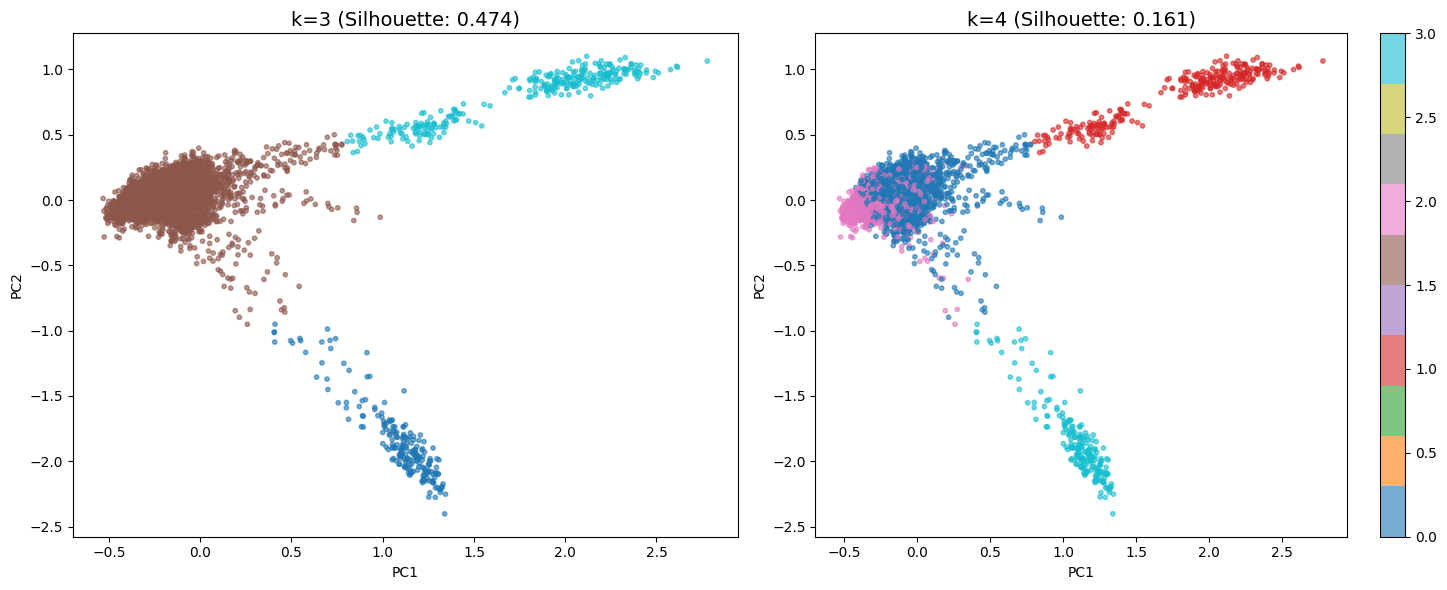


АНАЛИЗ РАСПРЕДЕЛЕНИЯ ДЛЯ k=3 И k=4

📊 k=3 кластера:
  Кластер 0: 215 (4.3%)
  Кластер 1: 4489 (89.8%)
  Кластер 2: 296 (5.9%)

📊 k=4 кластера:
  Кластер 0: 2955 (59.1%)
  Кластер 1: 296 (5.9%)
  Кластер 2: 1534 (30.7%)
  Кластер 3: 215 (4.3%)


In [27]:
# Визуализация для k=3 и k=4
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(doc_vectors)

axes[0].scatter(doc_vectors_2d[:, 0], doc_vectors_2d[:, 1],
                c=labels_3, cmap='tab10', alpha=0.6, s=10)
axes[0].set_title(f'k=3 (Silhouette: {silhouette_scores[1]:.3f})', fontsize=14)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_4 = kmeans_4.fit_predict(doc_vectors)

scatter = axes[1].scatter(doc_vectors_2d[:, 0], doc_vectors_2d[:, 1],
                          c=labels_4, cmap='tab10', alpha=0.6, s=10)
axes[1].set_title(f'k=4 (Silhouette: {silhouette_scores[2]:.3f})', fontsize=14)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.colorbar(scatter, ax=axes[1])
plt.tight_layout()
plt.show()

# Анализ распределения
print("\n" + "="*60)
print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ДЛЯ k=3 И k=4")
print("="*60)

print("\n📊 k=3 кластера:")
unique_3, counts_3 = np.unique(labels_3, return_counts=True)
for cls, count in zip(unique_3, counts_3):
    print(f"  Кластер {cls}: {count} ({count/len(labels_3)*100:.1f}%)")

print("\n📊 k=4 кластера:")
unique_4, counts_4 = np.unique(labels_4, return_counts=True)
for cls, count in zip(unique_4, counts_4):
    print(f"  Кластер {cls}: {count} ({count/len(labels_4)*100:.1f}%)")